In [1]:
from pandas.errors import SettingWithCopyWarning
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_wine
import optuna
warnings.filterwarnings('ignore')

In [2]:
"""
CSV MANIPULATION: All of the manipulation of the CSV files was done within the merge.py and winner_to_binary.py files. The merge.py file was used to 
merge every year of ATP Data into four batches: Data, Training, Validation, and Testing data. I then manipulated the data to switch up whether player 1 por player 2 won,
as this would be a tell for the algorithm. Because this work was all done within this script, much of the work was replaced. Additionally, once started the machine learning
portion of the project I had to change the winner_name variable (the variable to be predicted) to a binary variable in order for the algorithm to not predict players
that were not in the match. This script has been edited and ran multiple times as well.
"""

'\nCSV MANIPULATION: All of the manipulation of the CSV files was done within the merge.py and winner_to_binary.py files. The merge.py file was used to \nmerge every year of ATP Data into four batches: Data, Training, Validation, and Testing data. I then manipulated the data to switch up whether player 1 por player 2 won,\nas this would be a tell for the algorithm. Because this work was all done within this script, much of the work was replaced. Additionally, once started the machine learning\nportion of the project I had to change the winner_name variable (the variable to be predicted) to a binary variable in order for the algorithm to not predict players\nthat were not in the match. This script has been edited and ran multiple times as well.\n'

In [3]:
import csv
from collections import Counter

## Aggregate the match results in the csv files provided at
## https://github.com/JeffSackmann/tennis_atp and
## https://github.com/JeffSackmann/tennis_wta
## to create "player-season" rate stats, e.g. Ace% for Roger Federer in
## 2015 or SPW% for Sara Errani in 2021.

mw = 'm'  ## 'm' = men, 'w' = women
yrstart = 2010  ## first season to calculate totals
yrend = 2014  ## last season to calculate totals
match_min = 10  ## minimum number of matches (with matchstats)
## a player must have to be included for a given year
input_path = '../'  ## path to the single-season results csv files

if mw == 'm':
    prefix = 'atp'
else:
    prefix = 'wta'

output_path = '2010_2014_player_data.csv'

header = ['Player', 'Matches', 'Wins', 'Losses', 'Win%',
          'Ace%', 'DF%', '1stIn', '1st%', '2nd%',
          'SPW%', 'RPW%', 'TPW%', 'DomRatio']
player_seasons = [header]

## load one year of match results
matches = [row for row in csv.reader(open('Data2010_2014_statistics.csv'))]
## exclude incomplete/unplayed matches (e.g. "W/O" or "RET" in score]
matches = [k for k in matches if 'W' not in k[23] and 'R' not in k[23]]
## exclude matches without stats
matches = [k for k in matches if '' not in [k[27], k[36]]]
## make list of all players with a result
players = [k[10] for k in matches] + [k[18] for k in matches]
## limit list of players to those with at least match_min matches
qualifs = [k for k, v in Counter(players).items() if v >= match_min]

for pl in qualifs:
    ## find all of the players matches
    pmatches = [k for k in matches if pl in [k[10], k[18]]]
    ## make matrix of their stats (different columns depending if they won or lost)
    pstats = [k[27:36] + k[36:45] if pl == k[10] else k[36:45] + k[27:36] for k in pmatches]
    ## make row for their aggregate counting stats, starting with number of matches [with stats]
    sum_row = [len(pstats)]
    for i in range(len(pstats[0])):
        this_stat = sum([int(float(k[i])) for k in pstats])
        sum_row.append(this_stat)
    ## calculate aggregates
    match_count = len(pmatches)
    wins = len([k for k in pmatches if k[10] == pl])
    losses = match_count - wins
    win_perc = wins / float(match_count)

    ## readable names for serve stats
    aces, dfs, svpt, firstin, firstwon, secondwon = sum_row[1:7]
    ## calculate common rate stats
    ace_rate = aces / float(svpt)
    df_rate = dfs / float(svpt)
    firstin_rate = firstin / float(svpt)
    first_win = firstwon / float(firstin)
    second_win = secondwon / (svpt - float(firstin))
    spw = firstwon + secondwon
    spw_rate = spw / float(svpt)

    ## raw return stats
    vaces, vdfs, retpt, vfirstin, vfirstwon, vsecondwon = sum_row[10:16]
    ## calculate more aggregates
    rpw = retpt - vfirstwon - vsecondwon
    rpw_rate = rpw / float(retpt)

    tpw_rate = (spw + rpw) / (float(svpt) + retpt)
    dom_ratio = rpw_rate / (1 - spw_rate)

    row = [pl, match_count, wins, losses, win_perc,
            ace_rate, df_rate, firstin_rate, first_win, second_win,
            spw_rate, rpw_rate, tpw_rate, dom_ratio]
    player_seasons.append(row)

results = open(output_path, 'w')
writer = csv.writer(results)
for row in player_seasons:    writer.writerow(row)
results.close()

df = pd.read_csv('2010_2014_player_data.csv')
print(df)

                   Player  Matches  Wins  Losses      Win%      Ace%   
0            Andy Roddick      147   100      47  0.680272  0.150838  \
1            Carsten Ball       11     3       8  0.272727  0.120643   
2         Richard Gasquet      286   186     100  0.650350  0.075715   
3           Matthew Ebden       99    33      66  0.333333  0.069304   
4           Tomas Berdych      361   252     109  0.698061  0.104600   
..                    ...      ...   ...     ...       ...       ...   
238    Alejandro Gonzalez       28     8      20  0.285714  0.055029   
239  Aleksandr Nedovyesov       17     4      13  0.235294  0.072266   
240      Alexander Zverev       11     4       7  0.363636  0.058480   
241           Borna Coric       12     6       6  0.500000  0.080976   
242           Eric Prodon       10     0      10  0.000000  0.044100   

          DF%     1stIn      1st%      2nd%      SPW%      RPW%      TPW%   
0    0.022948  0.669550  0.773926  0.553686  0.701147  0.3

In [4]:
"""DATA COLLECTION:
Above I have manipulated a python script made by the owner of the dataset in order to look at player data from 2010-2014. Initially my hope was to factor this earlier
data into the machine learning program in order to create a better estimate. Due to time constraints this was not possible, but it is still interesting to see the
accumulated data of each player, and hopefully in the future I can factor this into my project.
"""

'DATA COLLECTION:\nAbove I have manipulated a python script made by the owner of the dataset in order to look at player data from 2010-2014. Initially my hope was to factor this earlier\ndata into the machine learning program in order to create a better estimate. Due to time constraints this was not possible, but it is still interesting to see the\naccumulated data of each player, and hopefully in the future I can factor this into my project.\n'

In [5]:
#get csv files into dataframes
training_data = pd.read_csv ('2015_2021_training_r.csv')
testing_data = pd.read_csv ('2022_testing_r.csv')
validation_data = pd.read_csv ('2021_validation_r.csv')

#isolate the target variable
training_label = np.array(training_data['winner_name'])
testing_label = np.array(testing_data['winner_name'])
validation_label = np.array(validation_data['winner_name'])

#get necessary variables for training and testing data
features_train = training_data[['tourney_name','surface','draw_size','tourney_level','tourney_date','match_num','p1_id','p1_seed','p1_name','p1_hand','p1_ht','p1_age','p2_id','p2_seed','p2_name','p2_hand','p2_ht','p2_age','p1_rank','p1_rank_points','p2_rank','p2_rank_points']]
features_val = validation_data[['tourney_name','surface','draw_size','tourney_level','tourney_date','match_num','p1_id','p1_seed','p1_name','p1_hand','p1_ht','p1_age','p2_id','p2_seed','p2_name','p2_hand','p2_ht','p2_age','p1_rank','p1_rank_points','p2_rank','p2_rank_points']]
features_test = testing_data[['tourney_name','surface','draw_size','tourney_level','tourney_date','match_num','p1_id','p1_seed','p1_name','p1_hand','p1_ht','p1_age','p2_id','p2_seed','p2_name','p2_hand','p2_ht','p2_age','p1_rank','p1_rank_points','p2_rank','p2_rank_points']]

In [6]:
#hotencode categorical variables
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
features_train["tourney_name"] = ord_enc.fit_transform(features_train[["tourney_name"]])
features_train["surface"] = ord_enc.fit_transform(features_train[["surface"]])
features_train["tourney_date"] = ord_enc.fit_transform(features_train[["tourney_date"]])
features_train["tourney_level"] = ord_enc.fit_transform(features_train[["tourney_level"]])
features_train["p1_name"] = ord_enc.fit_transform(features_train[["p1_name"]])
features_train["p2_name"] = ord_enc.fit_transform(features_train[["p2_name"]])
features_train["p1_hand"] = ord_enc.fit_transform(features_train[["p1_hand"]])
features_train["p2_hand"] = ord_enc.fit_transform(features_train[["p2_hand"]])

features_val["tourney_name"] = ord_enc.fit_transform(features_val[["tourney_name"]])
features_val["surface"] = ord_enc.fit_transform(features_val[["surface"]])
features_val["tourney_date"] = ord_enc.fit_transform(features_val[["tourney_date"]])
features_val["tourney_level"] = ord_enc.fit_transform(features_val[["tourney_level"]])
features_val["p1_name"] = ord_enc.fit_transform(features_val[["p1_name"]])
features_val["p2_name"] = ord_enc.fit_transform(features_val[["p2_name"]])
features_val["p1_hand"] = ord_enc.fit_transform(features_val[["p1_hand"]])
features_val["p2_hand"] = ord_enc.fit_transform(features_val[["p2_hand"]])

features_test["tourney_name"] = ord_enc.fit_transform(features_test[["tourney_name"]])
features_test["surface"] = ord_enc.fit_transform(features_test[["surface"]])
features_test["tourney_date"] = ord_enc.fit_transform(features_test[["tourney_date"]])
features_test["tourney_level"] = ord_enc.fit_transform(features_test[["tourney_level"]])
features_test["p1_name"] = ord_enc.fit_transform(features_test[["p1_name"]])
features_test["p2_name"] = ord_enc.fit_transform(features_test[["p2_name"]])
features_test["p1_hand"] = ord_enc.fit_transform(features_test[["p1_hand"]])
features_test["p2_hand"] = ord_enc.fit_transform(features_test[["p2_hand"]])

In [7]:
#impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# Num_vars is the list of numerical variables
X_train = pd.DataFrame(features_train)
features_train = imputer.fit_transform(features_train)
features_val = imputer.fit_transform(features_val)
features_test = imputer.fit_transform(features_test)


In [8]:
"""
MISSING VALUES: Above shows how within the training, validtion, and testing data I isolated the variables that were beneficial to determining the winner of the match
without giving any information about the match results. I then used hot one encoding in order to translate all of the categorical variables into numerical ones. Lastly,
I used imputation to fill in the missing values when necessary with the median. This is because there were missing values littered throughout the datasets and although
they didn't affect the program drastically it would have made it much harder to run.
"""

"\nMISSING VALUES: Above shows how within the training, validtion, and testing data I isolated the variables that were beneficial to determining the winner of the match\nwithout giving any information about the match results. I then used hot one encoding in order to translate all of the categorical variables into numerical ones. Lastly,\nI used imputation to fill in the missing values when necessary with the median. This is because there were missing values littered throughout the datasets and although\nthey didn't affect the program drastically it would have made it much harder to run.\n"

In [9]:
#traing and test
clf = RandomForestClassifier()
clf.fit(features_train, training_label)
preds = clf.predict(features_test)
print("Training accuracy: ", clf.score(features_train, training_label))
print("Testing accuracy: ", clf.score(features_test, testing_label))

Training accuracy:  1.0
Testing accuracy:  0.6133013369900583


In [10]:
print("Model Features Ranked: ")
print(pd.DataFrame(clf.feature_importances_, index=X_train.columns.values).sort_values(by=0, ascending=False))

Model Features Ranked: 
                       0
p2_rank_points  0.088234
p1_rank_points  0.086457
p1_rank         0.081899
p2_rank         0.077122
p2_age          0.060091
p1_age          0.059815
match_num       0.056684
tourney_date    0.055009
p2_name         0.053369
p1_name         0.052704
p1_id           0.052551
p2_id           0.050952
tourney_name    0.050228
p2_ht           0.036215
p1_ht           0.035834
p2_seed         0.024944
p1_seed         0.024564
draw_size       0.015678
surface         0.012256
tourney_level   0.010594
p2_hand         0.007439
p1_hand         0.007362


In [11]:
"""
VARIABLE EFFECTS: Above lists each variable as well as how much the program factored the variable into its decision. It's not a surprise that the top four variables 
the players ranking and rank points. This is because these four variables say a lot about how good each player is. It is interesting to see how age is the next
biggest factor as I wouldn't expect it to have a very large efffect.
"""

"\nVARIABLE EFFECTS: Above lists each variable as well as how much the program factored the variable into its decision. It's not a surprise that the top four variables \nthe players ranking and rank points. This is because these four variables say a lot about how good each player is. It is interesting to see how age is the next\nbiggest factor as I wouldn't expect it to have a very large efffect.\n"

In [12]:
clf_4 = RandomForestClassifier(max_depth=4)
clf_4.fit(features_train, training_label)
print("Accuracy on training set only using top 4 features: %f" % clf_4.score(features_train, training_label))
print("Accuracy on test set only using top 4 features: %f" % clf_4.score(features_test, testing_label))

Accuracy on training set only using top 4 features: 0.650992
Accuracy on test set only using top 4 features: 0.635585


In [13]:
#function for hypertuning
def objective(trial):

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(features_train, training_label)

    # Make predictions
    y_pred = optuna_model.predict(features_test)

    # Evaluate predictions
    accuracy = accuracy_score(testing_label, y_pred)
    return accuracy


In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2023-05-07 17:37:38,265] A new study created in memory with name: no-name-3fdf1dfc-47aa-41e4-ac5f-e8f87eead505
[I 2023-05-07 17:37:38,686] Trial 0 finished with value: 0.6348988687007199 and parameters: {'max_depth': 4, 'learning_rate': 0.015124696450833605, 'n_estimators': 230, 'min_child_weight': 6, 'gamma': 0.00019168770486618423, 'subsample': 0.1387374877826368, 'colsample_bytree': 0.014488049507196975, 'reg_alpha': 0.652806634542336, 'reg_lambda': 7.474476944629888e-08}. Best is trial 0 with value: 0.6348988687007199.
[I 2023-05-07 17:37:40,290] Trial 1 finished with value: 0.5711347274597189 and parameters: {'max_depth': 9, 'learning_rate': 0.18494190250842338, 'n_estimators': 459, 'min_child_weight': 4, 'gamma': 0.252403191343291, 'subsample': 0.1592712452343658, 'colsample_bytree': 0.26697423731989534, 'reg_alpha': 1.0973519345782484e-05, 'reg_lambda': 1.652379141408635e-07}. Best is trial 0 with value: 0.6348988687007199.
[I 2023-05-07 17:37:40,430] Trial 2 finished with va

[I 2023-05-07 17:37:49,965] Trial 19 finished with value: 0.6184436064449778 and parameters: {'max_depth': 1, 'learning_rate': 0.01675043874814536, 'n_estimators': 288, 'min_child_weight': 7, 'gamma': 0.000713152827405398, 'subsample': 0.23693289713877141, 'colsample_bytree': 0.010347912516438037, 'reg_alpha': 0.00027824029963102346, 'reg_lambda': 2.161814098684509e-07}. Best is trial 8 with value: 0.6400411381556393.
[I 2023-05-07 17:37:50,613] Trial 20 finished with value: 0.6359273225917038 and parameters: {'max_depth': 2, 'learning_rate': 0.01606514109603771, 'n_estimators': 383, 'min_child_weight': 4, 'gamma': 3.571540836771852e-05, 'subsample': 0.5471660769779556, 'colsample_bytree': 0.07982383329437208, 'reg_alpha': 0.01858977174089882, 'reg_lambda': 4.085502389096383e-08}. Best is trial 8 with value: 0.6400411381556393.
[I 2023-05-07 17:37:51,307] Trial 21 finished with value: 0.6379842303736716 and parameters: {'max_depth': 2, 'learning_rate': 0.015769421771293816, 'n_estimato

[I 2023-05-07 17:38:03,104] Trial 38 finished with value: 0.646554679465204 and parameters: {'max_depth': 2, 'learning_rate': 0.026708233108743616, 'n_estimators': 408, 'min_child_weight': 3, 'gamma': 1.7336746819929786e-05, 'subsample': 0.28352295736962096, 'colsample_bytree': 0.17104103213336364, 'reg_alpha': 0.2521257168444201, 'reg_lambda': 1.4643646870319612e-07}. Best is trial 38 with value: 0.646554679465204.
[I 2023-05-07 17:38:03,838] Trial 39 finished with value: 0.6410695920466233 and parameters: {'max_depth': 2, 'learning_rate': 0.027720004531552156, 'n_estimators': 487, 'min_child_weight': 3, 'gamma': 5.763300893731728e-05, 'subsample': 0.09855220875328746, 'colsample_bytree': 0.1609977088638472, 'reg_alpha': 0.21667526458984282, 'reg_lambda': 9.092389321013607e-08}. Best is trial 38 with value: 0.646554679465204.
[I 2023-05-07 17:38:04,594] Trial 40 finished with value: 0.6390126842646555 and parameters: {'max_depth': 2, 'learning_rate': 0.026699291514482356, 'n_estimator

[I 2023-05-07 17:38:14,469] Trial 57 finished with value: 0.6444977716832362 and parameters: {'max_depth': 1, 'learning_rate': 0.03688611664184769, 'n_estimators': 387, 'min_child_weight': 1, 'gamma': 7.687751934954559e-08, 'subsample': 0.3177698575802381, 'colsample_bytree': 0.23470035474160852, 'reg_alpha': 0.024087395122661382, 'reg_lambda': 1.5623583983051416e-05}. Best is trial 50 with value: 0.6468974974288653.
[I 2023-05-07 17:38:17,329] Trial 58 finished with value: 0.5923894412067192 and parameters: {'max_depth': 9, 'learning_rate': 0.057082920038240594, 'n_estimators': 424, 'min_child_weight': 1, 'gamma': 3.562041452244345e-07, 'subsample': 0.2581757367528529, 'colsample_bytree': 0.461539759946244, 'reg_alpha': 0.013432584839161125, 'reg_lambda': 3.2270515511767565e-07}. Best is trial 50 with value: 0.6468974974288653.
[I 2023-05-07 17:38:17,881] Trial 59 finished with value: 0.6427836818649297 and parameters: {'max_depth': 1, 'learning_rate': 0.03228958967823824, 'n_estimato

[I 2023-05-07 17:38:29,338] Trial 76 finished with value: 0.6462118615015426 and parameters: {'max_depth': 1, 'learning_rate': 0.029958585798477346, 'n_estimators': 405, 'min_child_weight': 2, 'gamma': 1.1419476312643685e-08, 'subsample': 0.1871210566887668, 'colsample_bytree': 0.25460810072776097, 'reg_alpha': 0.15938161288802186, 'reg_lambda': 2.0219154879581015e-07}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:38:30,021] Trial 77 finished with value: 0.6369557764826876 and parameters: {'max_depth': 2, 'learning_rate': 0.03063222638483427, 'n_estimators': 363, 'min_child_weight': 2, 'gamma': 1.1320494133210073e-08, 'subsample': 0.18572549673974637, 'colsample_bytree': 0.30025719930886147, 'reg_alpha': 0.1374883578355301, 'reg_lambda': 2.6815241771393904e-07}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:38:30,730] Trial 78 finished with value: 0.6455262255742201 and parameters: {'max_depth': 1, 'learning_rate': 0.03475419563386802, 'n_estima

[I 2023-05-07 17:38:40,799] Trial 95 finished with value: 0.6438121357559136 and parameters: {'max_depth': 1, 'learning_rate': 0.02650500136719579, 'n_estimators': 397, 'min_child_weight': 1, 'gamma': 4.1335823718521406e-08, 'subsample': 0.33452849043011723, 'colsample_bytree': 0.22106594427684478, 'reg_alpha': 0.275878236431902, 'reg_lambda': 1.5788034899052136e-07}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:38:42,283] Trial 96 finished with value: 0.6321563249914296 and parameters: {'max_depth': 6, 'learning_rate': 0.029817024305641433, 'n_estimators': 420, 'min_child_weight': 2, 'gamma': 9.757973845060168e-08, 'subsample': 0.23370542902652452, 'colsample_bytree': 0.25600018545677566, 'reg_alpha': 0.1668661933561933, 'reg_lambda': 1.6816161230832755e-06}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:38:43,060] Trial 97 finished with value: 0.6417552279739458 and parameters: {'max_depth': 2, 'learning_rate': 0.02290960510731439, 'n_estimato

[I 2023-05-07 17:38:57,078] Trial 114 finished with value: 0.6420980459376071 and parameters: {'max_depth': 2, 'learning_rate': 0.016385802405676952, 'n_estimators': 451, 'min_child_weight': 2, 'gamma': 5.179101124129022e-08, 'subsample': 0.26207889141482954, 'colsample_bytree': 0.21517693110064676, 'reg_alpha': 0.676678481346854, 'reg_lambda': 2.046848240702865e-06}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:38:57,632] Trial 115 finished with value: 0.643126499828591 and parameters: {'max_depth': 1, 'learning_rate': 0.02363553783119236, 'n_estimators': 400, 'min_child_weight': 1, 'gamma': 1.96050937541588e-07, 'subsample': 0.1706921495810173, 'colsample_bytree': 0.15405325389463467, 'reg_alpha': 0.16832074411307085, 'reg_lambda': 1.02749247681727e-06}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:38:58,394] Trial 116 finished with value: 0.6427836818649297 and parameters: {'max_depth': 1, 'learning_rate': 0.034368077923379724, 'n_estimators

[I 2023-05-07 17:39:09,363] Trial 133 finished with value: 0.6455262255742201 and parameters: {'max_depth': 1, 'learning_rate': 0.04323845994866157, 'n_estimators': 395, 'min_child_weight': 1, 'gamma': 1.4545016165247665e-07, 'subsample': 0.23531238574218544, 'colsample_bytree': 0.2264921422915485, 'reg_alpha': 0.02153295721928946, 'reg_lambda': 5.252090493893801e-07}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:39:09,940] Trial 134 finished with value: 0.6434693177922524 and parameters: {'max_depth': 1, 'learning_rate': 0.05258830850307805, 'n_estimators': 409, 'min_child_weight': 1, 'gamma': 3.252737738072999e-07, 'subsample': 0.2105472118535076, 'colsample_bytree': 0.3024369597179852, 'reg_alpha': 0.07896747418785612, 'reg_lambda': 3.0201372752600186e-07}. Best is trial 74 with value: 0.6482687692835104.
[I 2023-05-07 17:39:10,432] Trial 135 finished with value: 0.6400411381556393 and parameters: {'max_depth': 1, 'learning_rate': 0.0674235964363705, 'n_estimato

Number of finished trials: 150
Best trial:
  Value: 0.6503256770654783
  Params: 
    max_depth: 1
    learning_rate: 0.04513951741953903
    n_estimators: 399
    min_child_weight: 1
    gamma: 4.930698975563402e-07
    subsample: 0.21100530718862612
    colsample_bytree: 0.24915342961737086
    reg_alpha: 0.11146991406155919
    reg_lambda: 8.150941792107757e-07


In [15]:
params = trial.params
model = XGBClassifier(**params)
model.fit(features_train, training_label)
y_pred = model.predict(features_test)
accuracy = accuracy_score(testing_label, y_pred)
print("Accuracy on test data after tuning: %.2f%%" % (accuracy * 100.0))
print(classification_report(testing_label, y_pred))

Accuracy on test data after tuning: 65.03%
              precision    recall  f1-score   support

           0       0.64      0.68      0.66      1452
           1       0.66      0.62      0.64      1465

    accuracy                           0.65      2917
   macro avg       0.65      0.65      0.65      2917
weighted avg       0.65      0.65      0.65      2917



In [16]:
"""
HYPERTUNING RESULTS: Above we have the results and the best parameters after hypertuning our tree algorithm. It is is clear that our accuracy is multiple percent
larger than the original value. Not only is this true, but it shows that our precision and recall are also pretty good for both player 1 winning (1) and player 2
winning (0). Now we can use these parameters and hypertune with early stopping.
"""

'\nHYPERTUNING RESULTS: Above we have the results and the best parameters after hypertuning our tree algorithm. It is is clear that our accuracy is multiple percent\nlarger than the original value. Not only is this true, but it shows that our precision and recall are also pretty good for both player 1 winning (1) and player 2\nwinning (0). Now we can use these parameters and hypertune with early stopping.\n'

In [17]:
#now use early stopping on best hypertuned parameters
cls = xgb.XGBClassifier(**params)
cls.fit(features_train, training_label, eval_set=[(features_train, training_label), (features_val, validation_label)],
            early_stopping_rounds=20)

[0]	validation_0-logloss:0.69188	validation_1-logloss:0.69192
[1]	validation_0-logloss:0.69049	validation_1-logloss:0.69053
[2]	validation_0-logloss:0.69027	validation_1-logloss:0.69031
[3]	validation_0-logloss:0.68871	validation_1-logloss:0.68890
[4]	validation_0-logloss:0.68692	validation_1-logloss:0.68752
[5]	validation_0-logloss:0.68590	validation_1-logloss:0.68654
[6]	validation_0-logloss:0.68452	validation_1-logloss:0.68510
[7]	validation_0-logloss:0.68332	validation_1-logloss:0.68382
[8]	validation_0-logloss:0.68317	validation_1-logloss:0.68362
[9]	validation_0-logloss:0.68195	validation_1-logloss:0.68233
[10]	validation_0-logloss:0.68050	validation_1-logloss:0.68105
[11]	validation_0-logloss:0.67983	validation_1-logloss:0.68034
[12]	validation_0-logloss:0.67919	validation_1-logloss:0.67972
[13]	validation_0-logloss:0.67807	validation_1-logloss:0.67852
[14]	validation_0-logloss:0.67804	validation_1-logloss:0.67852
[15]	validation_0-logloss:0.67678	validation_1-logloss:0.67748
[1

[130]	validation_0-logloss:0.63556	validation_1-logloss:0.63962
[131]	validation_0-logloss:0.63526	validation_1-logloss:0.63944
[132]	validation_0-logloss:0.63512	validation_1-logloss:0.63924
[133]	validation_0-logloss:0.63500	validation_1-logloss:0.63911
[134]	validation_0-logloss:0.63496	validation_1-logloss:0.63902
[135]	validation_0-logloss:0.63472	validation_1-logloss:0.63884
[136]	validation_0-logloss:0.63459	validation_1-logloss:0.63867
[137]	validation_0-logloss:0.63434	validation_1-logloss:0.63849
[138]	validation_0-logloss:0.63433	validation_1-logloss:0.63853
[139]	validation_0-logloss:0.63418	validation_1-logloss:0.63848
[140]	validation_0-logloss:0.63405	validation_1-logloss:0.63845
[141]	validation_0-logloss:0.63401	validation_1-logloss:0.63839
[142]	validation_0-logloss:0.63382	validation_1-logloss:0.63822
[143]	validation_0-logloss:0.63356	validation_1-logloss:0.63810
[144]	validation_0-logloss:0.63339	validation_1-logloss:0.63800
[145]	validation_0-logloss:0.63324	valid

[259]	validation_0-logloss:0.62428	validation_1-logloss:0.62978
[260]	validation_0-logloss:0.62425	validation_1-logloss:0.62967
[261]	validation_0-logloss:0.62420	validation_1-logloss:0.62971
[262]	validation_0-logloss:0.62414	validation_1-logloss:0.62976
[263]	validation_0-logloss:0.62411	validation_1-logloss:0.62973
[264]	validation_0-logloss:0.62409	validation_1-logloss:0.62978
[265]	validation_0-logloss:0.62405	validation_1-logloss:0.62977
[266]	validation_0-logloss:0.62401	validation_1-logloss:0.62965
[267]	validation_0-logloss:0.62398	validation_1-logloss:0.62959
[268]	validation_0-logloss:0.62393	validation_1-logloss:0.62953
[269]	validation_0-logloss:0.62390	validation_1-logloss:0.62943
[270]	validation_0-logloss:0.62384	validation_1-logloss:0.62951
[271]	validation_0-logloss:0.62378	validation_1-logloss:0.62947
[272]	validation_0-logloss:0.62374	validation_1-logloss:0.62935
[273]	validation_0-logloss:0.62372	validation_1-logloss:0.62928
[274]	validation_0-logloss:0.62369	valid

[388]	validation_0-logloss:0.62043	validation_1-logloss:0.62640
[389]	validation_0-logloss:0.62040	validation_1-logloss:0.62630
[390]	validation_0-logloss:0.62038	validation_1-logloss:0.62635
[391]	validation_0-logloss:0.62037	validation_1-logloss:0.62609
[392]	validation_0-logloss:0.62037	validation_1-logloss:0.62610
[393]	validation_0-logloss:0.62034	validation_1-logloss:0.62606
[394]	validation_0-logloss:0.62030	validation_1-logloss:0.62609
[395]	validation_0-logloss:0.62027	validation_1-logloss:0.62611
[396]	validation_0-logloss:0.62024	validation_1-logloss:0.62605
[397]	validation_0-logloss:0.62022	validation_1-logloss:0.62594
[398]	validation_0-logloss:0.62017	validation_1-logloss:0.62590


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.24915342961737086, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.930698975563402e-07, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04513951741953903, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=399, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
results = cls.evals_result()

print("The best tree length: ", model.best_ntree_limit)

The best tree length:  399


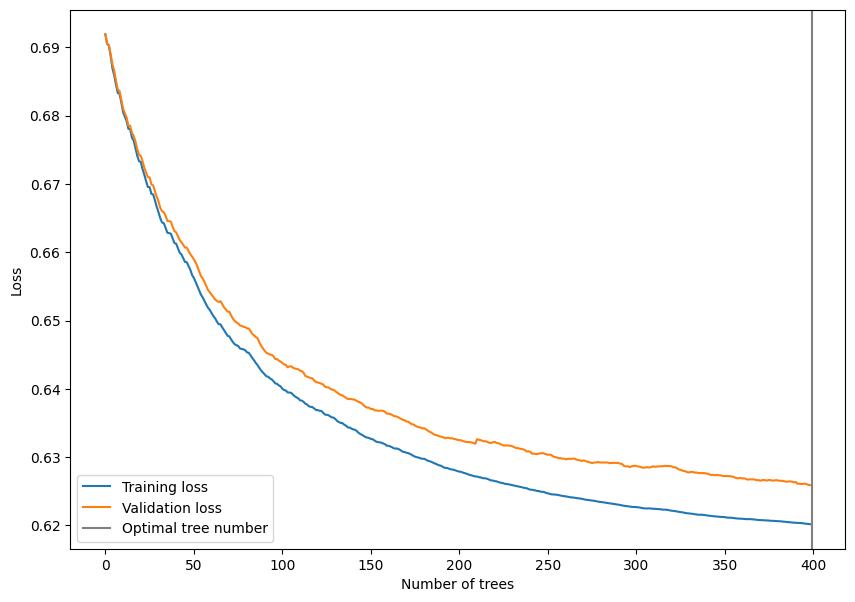

In [20]:
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.savefig("NumberOfTrees.svg")

In [ ]:
"""
EARLY STOPPING: It seems that the model suggests that the larger the tree length the better as validation loss is continually decreasing. Because of this the metrics 
after running hyperparameter tuning with early stopping are exactly the same as before. This is quite interesting and I'm not exactly sure how to interpret these results.
"""

In [ ]:
"""
RESULTS: Overall, our machine learning program was able to predict the winner of a given match with around a 65% accuracy after hyperparameter tuning. I am happy with
these results as sports are difficult to gauge and therefore I didn't expect a very high number for this project. Being correct approximately 2/3 of the time is far
better than randomly selecting a winner and probably better than if I were to manually guess. Hopefully in the future I will be able to incorporate my accumulative player
data as well as adjust the hyperparameters to make my model even more accurate.
"""